# **Comparison of PVW and EEQ homogenization schemes**

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from bmcs_matmod.ms1 import MS13DPVW
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy
import time

## PVW approach

Macroscopic tensor $\sigma$ is derived from 
\begin{equation}
\sigma_{ij} \delta \varepsilon_{ij} = \frac{3}{2\pi} \int_{\Omega} \sigma_{\mathrm{N}} \delta \varepsilon_{\mathrm{N}} \,\mathrm{d}\Omega + \frac{3}{2\pi} \int_{\Omega} \sigma_{\mathrm{T}_r}  \,
\delta \varepsilon_{\mathrm{T}_r} \, \mathrm{d}\Omega.
\label{eq:sigma_ij}
\end{equation}

By making use of the kinematic constraint

\begin{align}
\label{eq:epsilon_NT}
\varepsilon_{\mathrm{N}} &= \varepsilon_{ij} n_i n_j \\
\varepsilon_{\mathrm{T}_r} &= \frac{1}{2}(n_i \delta_{jr} + n_j \delta_{ir} - 2 n_i n_j n_r) \varepsilon_{ij} \nonumber
\end{align}

After operating
\begin{equation}
\sigma_{ij} = \frac{3}{2\pi} \int_{\Omega} \sigma_{\mathrm{N}} n_i n_j \,\mathrm{d}\Omega + \frac{3}{2\pi} \int_{\Omega} \frac{\sigma_{\mathrm{T}_r}}{2} \,
\left(n_i \delta_{rj} + n_j \delta_{ri}\right) \, \mathrm{d}\Omega.
\label{eq:sigma_ij}
\end{equation}

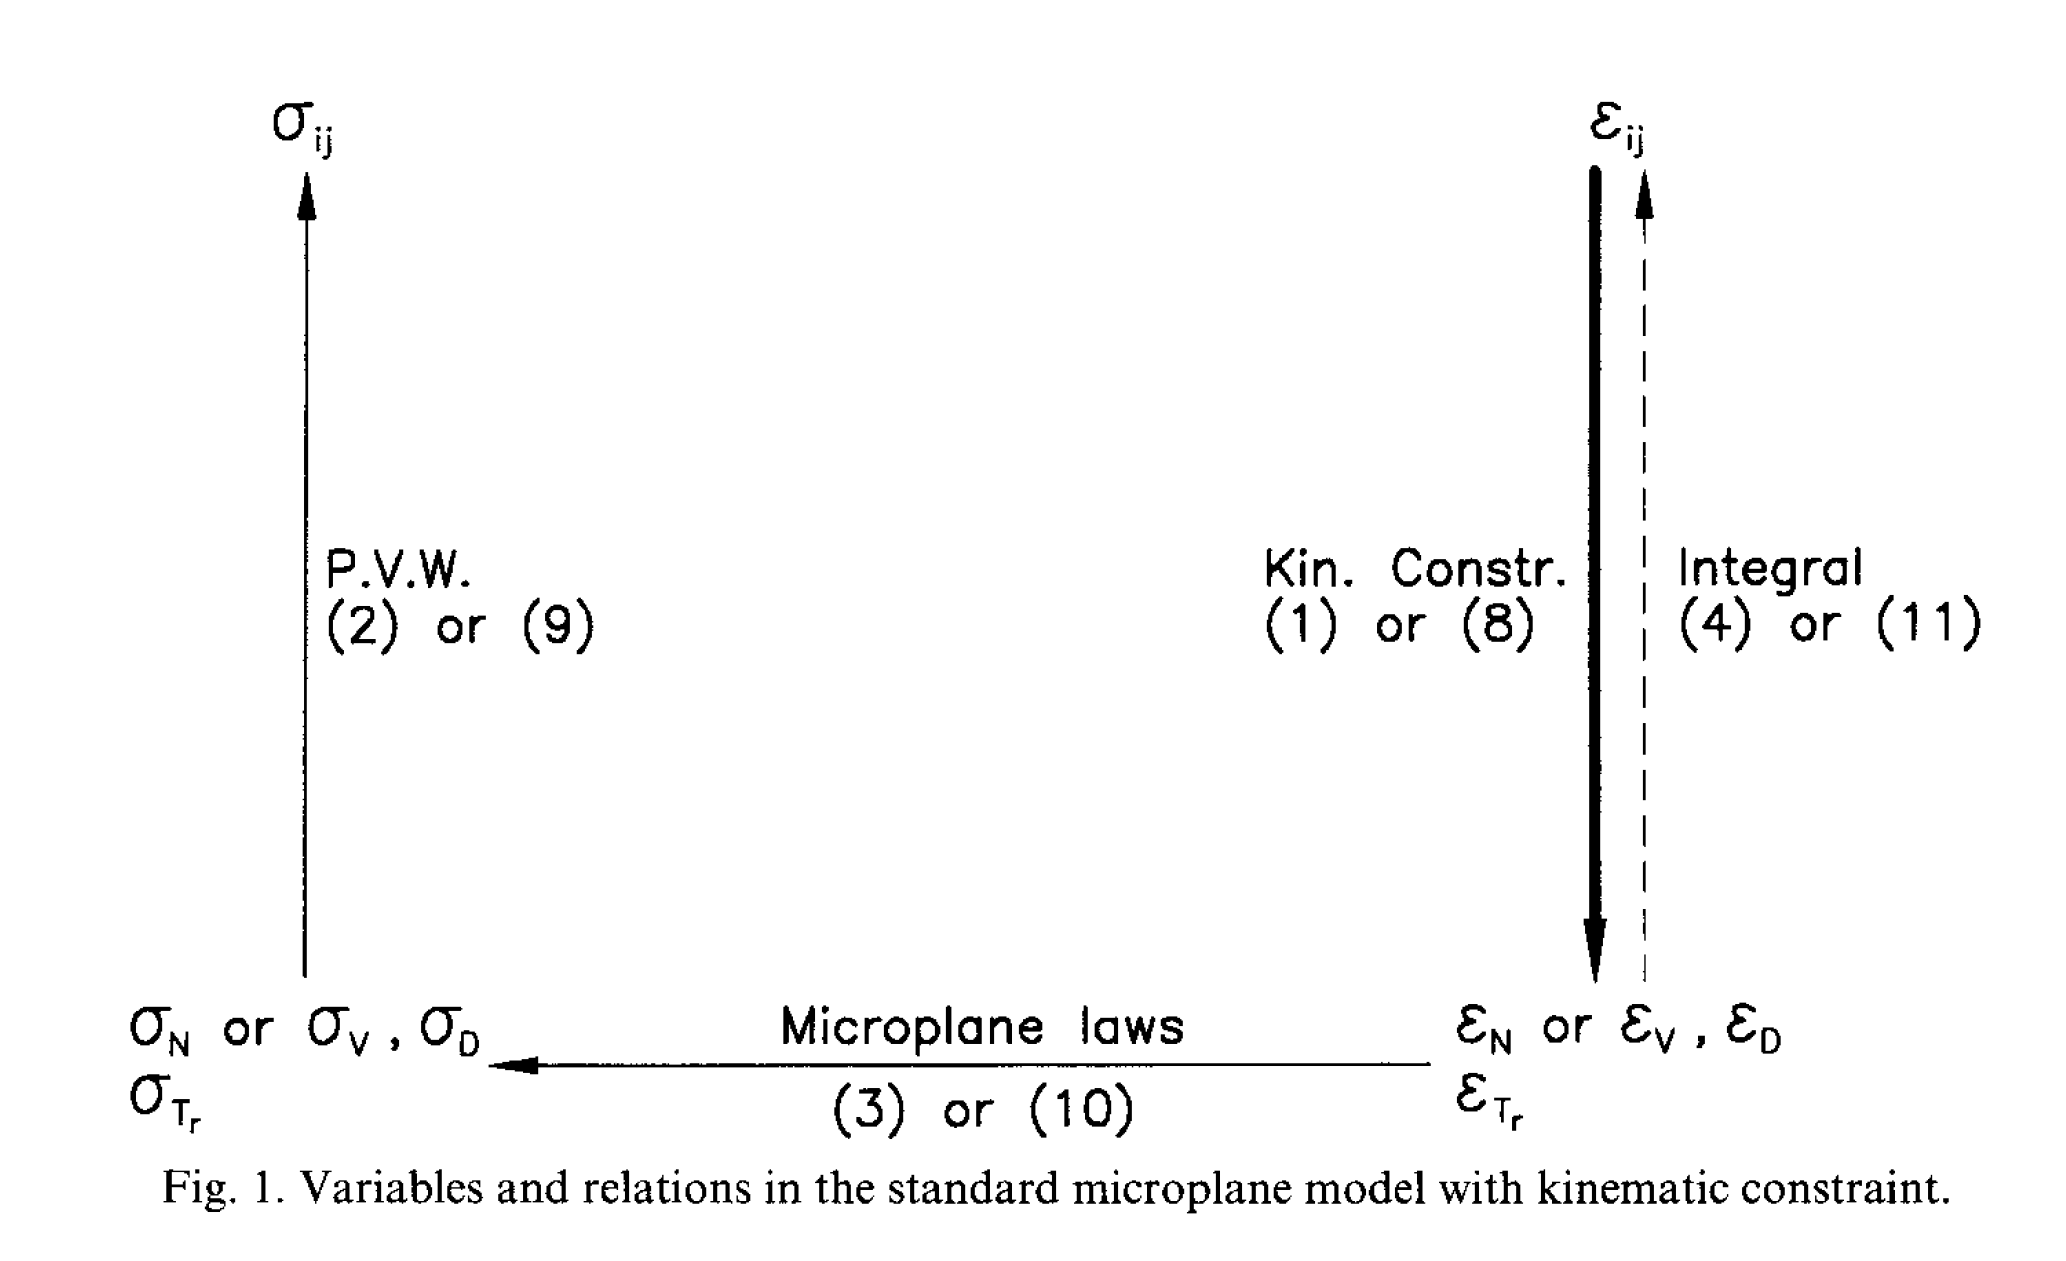

In [92]:
from IPython.display import Image
Image(filename="C:\\Users\\marag\\Escritorio\\Capture.png")

Furthermore, a purely thermodynamic derivation is possible as well

\begin{equation}
\psi^{mac} = \frac{3}{2\pi} \int_{\Omega} \psi^{mic} d\Omega 
\label{eq:psi_mac_mic}
\end{equation}




\begin{equation}
\sigma_{ij} = \frac{\partial(\rho_0\psi^{mac})}{\partial\varepsilon_{ij}} = \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic})}{\partial\varepsilon_{ij}} d\Omega  = \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{N})}{\partial\varepsilon_{ij}} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{T})}{\partial\varepsilon_{ij}} d\Omega
\label{eq:sigma_psi_mac}
\end{equation}



Applying the chain rule on the right handside
\begin{equation}
\frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{N})}{\partial\varepsilon_{ij}} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{T})}{\partial\varepsilon_{ij}} d\Omega = \frac{3}{2\pi} \int_{\Omega} 
\frac{\partial(\rho_0\psi^{mic}_\mathrm{N})}{\partial\varepsilon_\mathrm{N}} \frac{\partial\varepsilon_\mathrm{N}} {\partial\varepsilon_{ij}} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{T})}{\partial\varepsilon_{\mathrm{T}_r}} \frac{\partial\varepsilon_{\mathrm{T}_r}} {\partial\varepsilon_{ij}} d\Omega
\end{equation}



Applying the kinematic constraint
\begin{equation}
\frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{N})}{\partial\varepsilon_\mathrm{N}} \frac{\partial\varepsilon_\mathrm{N}} {\partial\varepsilon_{ij}} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{T})}{\partial\varepsilon_{\mathrm{T}_r}} \frac{\partial\varepsilon_{\mathrm{T}_r}} {\partial\varepsilon_{ij}} d\Omega = 
\frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{N})}{\partial\varepsilon_\mathrm{N}} N_{ij} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{T})}{\partial\varepsilon_{\mathrm{T}_r}} T_{rij} d\Omega
\end{equation}



\begin{equation}
\frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{N})}{\partial\varepsilon_\mathrm{N}} N_{ij} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \frac{\partial(\rho_0\psi^{mic}_\mathrm{T})}{\partial\varepsilon_{\mathrm{T}_r}} T_{rij} d\Omega = 
\frac{3}{2\pi} \int_{\Omega} \sigma_\mathrm{N} N_{ij} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \sigma_{\mathrm{T}_r} T_{rij} d\Omega 
\end{equation}



So that remains: 

\begin{equation}
\sigma_{ij}=
\frac{3}{2\pi} \int_{\Omega} \sigma_\mathrm{N} N_{ij} d\Omega  + \frac{3}{2\pi} \int_{\Omega} \sigma_{\mathrm{T}_r} T_{rij} d\Omega 
\label{eq:sigma_mac_sigma_mic}
\end{equation}



with:

\begin{equation}
N_{ij}= n_i n_j\\
T_{rij}= \frac{1}{2}(n_i \delta_{jr} + n_j \delta_{ir} - 2 n_i n_j n_r)
\end{equation}



## EEQ approach

Macroscopic tensor $\sigma$ is obtained as follows
\begin{equation}
\label{eq:corrector_predictor}
\boldsymbol{\sigma} = \boldsymbol{C}:(\boldsymbol{\varepsilon} - \boldsymbol{\varepsilon}^\mathrm{p}). 
\end{equation}

Macroscopic plastic tensor is obtained as: 
\begin{align} \label{eq:plastic_strain_tensor} 
\varepsilon^{p}_{ij} &= \frac{3}{2 \pi} \int_{\Omega}  \varepsilon^{p,\mathrm{mic}}_\mathrm{N}  n_i n_j  d \Omega + \frac{3}{2 \pi} \int_{\Omega} \frac{\varepsilon^{\pi,\mathrm{mic}}_{\mathrm{T}r}}{2} (n_i  \delta_{rj} + n_j \delta_{ri}) d \Omega.
\end{align}

\begin{equation} 
 \boldsymbol{C}=\boldsymbol{\beta}:\boldsymbol{C}^{\mathrm{e}}:\boldsymbol{\beta}^{\mathrm{T}}.
\end{equation}

The rank four damage inverse/integrity tensor $\boldsymbol{\beta}$ representing the 3D damage state can be obtained by integrating the normal and tangential microplane damage parameters according to as follows

\begin{align} \label{eq:integrity_tensor} 
    \boldsymbol{\beta}_{ijkl} &=  \frac{3}{2 \pi} \int_{\Omega}  \beta_\mathrm{N}^\mathrm{mic} \; n_i \; n_j \; n_k \; n_l \;d \Omega +   \frac{3}{2 \pi} \int_{\Omega} \dfrac{\beta_\mathrm{T}^\mathrm{mic} }{4} (n_i \; n_k \delta_{jl} + n_i \; n_l \delta_{jk}  + n_j \; n_k \delta_{il} + n_j \; n_l \delta_{ik} - 4 n_i \; n_j \; n_k \; n_l) \;d \Omega,
\end{align}

In [5]:
# Reference parameters

CAxisymm = dict(
    E = 39226,
    nu = 0.18,
    Ad = 700.0,
    eps_0 = 0.00001,
    K_N = 100.,
    sigma_N_0 = 20.,
    gamma_N = 200.,
    sigma_T_0 = 0.5,
    K_T = 0.0,
    gamma_T = 500,
    S_T = 0.001,
    c_T = 6.,
    r_T = 4.,
    m_T = 0.0,
    p_T = 10.
)

## Unit element tension - EEQ

In [54]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m_tension_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [55]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [56]:
w_max = 0.01

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [57]:
m_tension_EEQ.bc=bc1

m_tension_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 32.75350618362427 s


Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 700.0, 'eps_0': 1e-05, 'K_N': 100.0, 'sigma_N_0': 20.0, 'gamma_N': 200.0, 'sigma_T_0': 0.5, 'K_T': 0.0, 'gamma_T': 500, 'S_T': 0.001, 'c_T': 6.0, 'r_T': 4.0, 'm_T': 0.0, 'p_T': 10.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
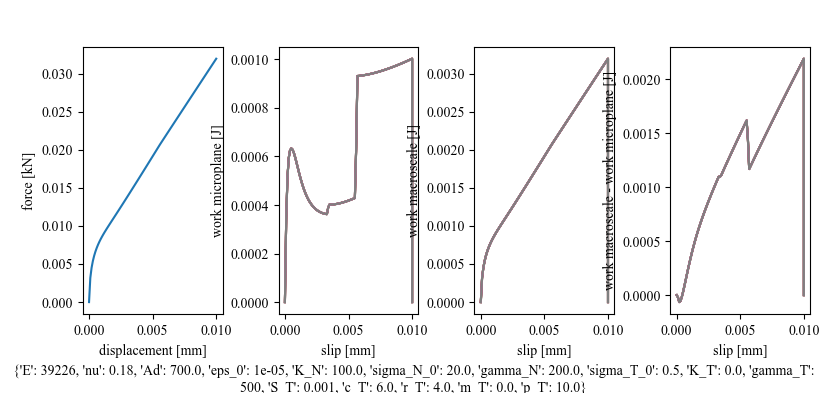

In [58]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile = np.average(m_tension_EEQ.hist.U_t[:, compression_dofs], axis=-1)
F_tensile = np.sum(m_tension_EEQ.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile)))

ax1.plot(U_tensile, F_tensile/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane = np.zeros((len(m_tension_EEQ.hist.state_vars),8))
total_work_macro = np.zeros((len(m_tension_EEQ.hist.state_vars),8))
for i in range(len(U_tensile)):
    total_work_microplane[i] = np.array([ m_tension_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro[i] = np.array([ m_tension_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(U_tensile, total_work_microplane, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile, total_work_macro, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile, total_work_macro - total_work_microplane, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

## Unit element tension - PVW

In [59]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW(**CAxisymm)
m_tension_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [60]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [61]:
w_max = 0.01

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [62]:
m_tension_PVW.bc=bc1

m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_tension_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 5.727811574935913 s


Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 700.0, 'eps_0': 1e-05, 'K_N': 100.0, 'sigma_N_0': 20.0, 'gamma_N': 200.0, 'sigma_T_0': 0.5, 'K_T': 0.0, 'gamma_T': 500, 'S_T': 0.001, 'c_T': 6.0, 'r_T': 4.0, 'm_T': 0.0, 'p_T': 10.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
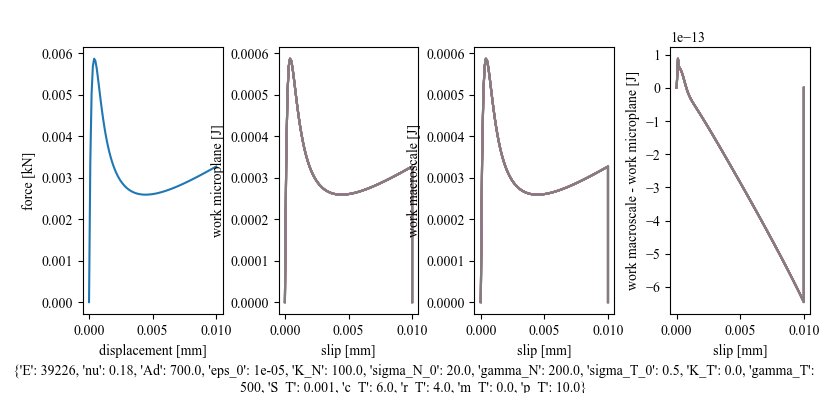

In [63]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_tensile = np.average(m_tension_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_tensile = np.sum(m_tension_PVW.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_tensile)))

ax1.plot(U_tensile, F_tensile/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane = np.zeros((len(m_tension_PVW.hist.state_vars),8))
total_work_macro = np.zeros((len(m_tension_PVW.hist.state_vars),8))
for i in range(len(U_tensile)):
    total_work_microplane[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro[i] = np.array([ m_tension_PVW.hist.state_vars[i][0]['total_work_macro']])

# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax2.plot(U_tensile, total_work_microplane, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_tensile, total_work_macro, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(U_tensile, total_work_macro - total_work_microplane, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

## Unit element compression - EEQ

In [64]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m_compression_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [65]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [66]:
w_max = -0.02

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [67]:
m_compression_EEQ.bc=bc1

m_compression_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 11.090742111206055 s


Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 700.0, 'eps_0': 1e-05, 'K_N': 100.0, 'sigma_N_0': 20.0, 'gamma_N': 200.0, 'sigma_T_0': 0.5, 'K_T': 0.0, 'gamma_T': 500, 'S_T': 0.001, 'c_T': 6.0, 'r_T': 4.0, 'm_T': 0.0, 'p_T': 10.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
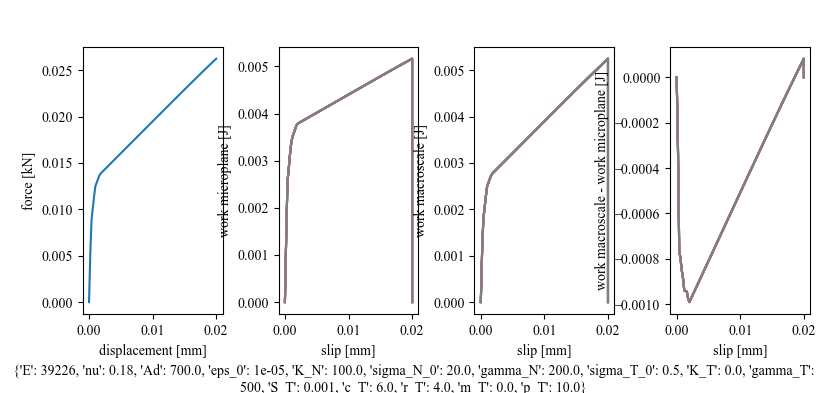

In [84]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression = np.average(m_compression_EEQ.hist.U_t[:, compression_dofs], axis=-1)
F_compression = np.sum(m_compression_EEQ.hist.F_t[:, compression_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_compression, -F_compression/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane = np.zeros((len(m_compression_EEQ.hist.state_vars),8))
total_work_macro = np.zeros((len(m_compression_EEQ.hist.state_vars),8))
for i in range(len(U_compression)):
    total_work_microplane[i] = np.array([ m_compression_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro[i] = np.array([ m_compression_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression, total_work_microplane, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression, total_work_macro, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression, total_work_macro - total_work_microplane, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

## Unit element compression - PVW

In [74]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW(**CAxisymm)
m_compression_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [75]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [76]:
w_max = -0.02

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [77]:
m_compression_PVW.bc=bc1

m_compression_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_compression_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
# s.run()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 10.936139583587646 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
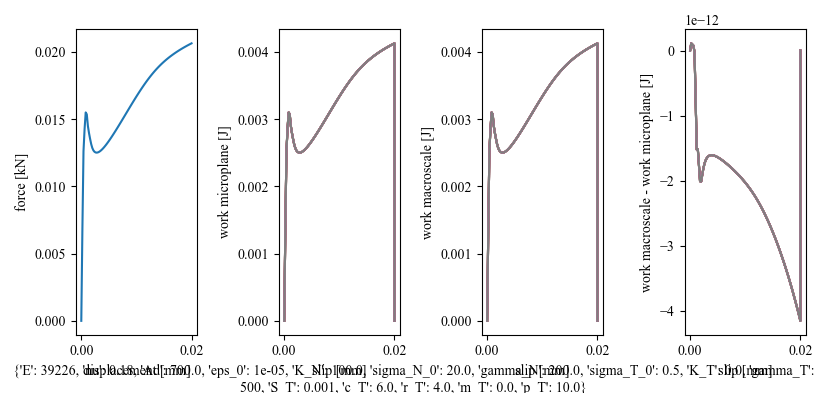

In [89]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_compression = np.average(m_compression_PVW.hist.U_t[:, compression_dofs], axis=-1)
F_compression = np.sum(m_compression_PVW.hist.F_t[:, compression_dofs], axis=-1)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_compression, -F_compression/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane = np.zeros((len(m_compression_PVW.hist.state_vars),8))
total_work_macro = np.zeros((len(m_compression_PVW.hist.state_vars),8))
for i in range(len(U_tensile)):
    total_work_microplane[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro[i] = np.array([ m_compression_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_compression, total_work_microplane, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_compression, total_work_macro, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_compression, total_work_macro - total_work_microplane, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()


# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

## Unit element shear - EEQ

In [98]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m_shear_EEQ = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [99]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [100]:
w_max = -0.05

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [101]:
m_shear_EEQ.bc=bc1

m_shear_EEQ.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_EEQ.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 45.69978713989258 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
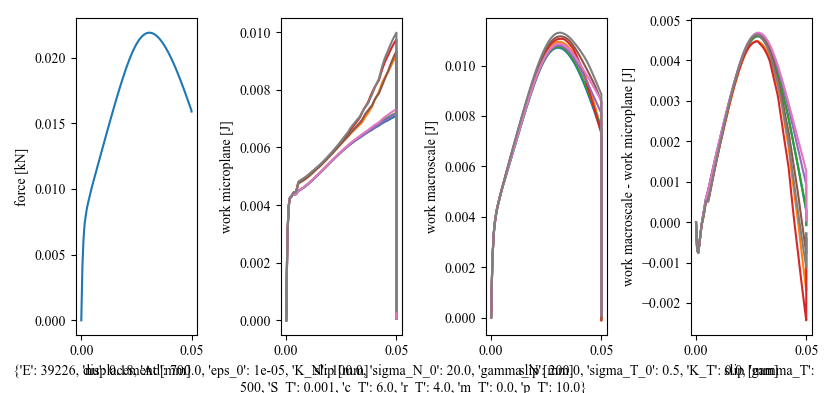

In [103]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide = np.average(m_shear_EEQ.hist.U_t[:, slide_dofs], axis=-1)
F_slide = np.sum(m_shear_EEQ.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide, -F_slide/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
total_work_macro = np.zeros((len(m_shear_EEQ.hist.state_vars),8))
for i in range(len(U_slide)):
    total_work_microplane[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro[i] = np.array([ m_shear_EEQ.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide, total_work_microplane, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide, total_work_macro, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide, total_work_macro - total_work_microplane, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

## Unit element shear - EEQ

In [104]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13DPVW(**CAxisymm)
m_shear_PVW = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [105]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [106]:
w_max = -0.05

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [support, slide_slice, compression_slice, back_side]

In [107]:
m_shear_PVW.bc=bc1

m_shear_PVW.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m_shear_PVW.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
start = time.time()
s.run()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass
end = time.time()
print('computational time: ' + str(end - start) + ' s')

computational time: 56.2461838722229 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
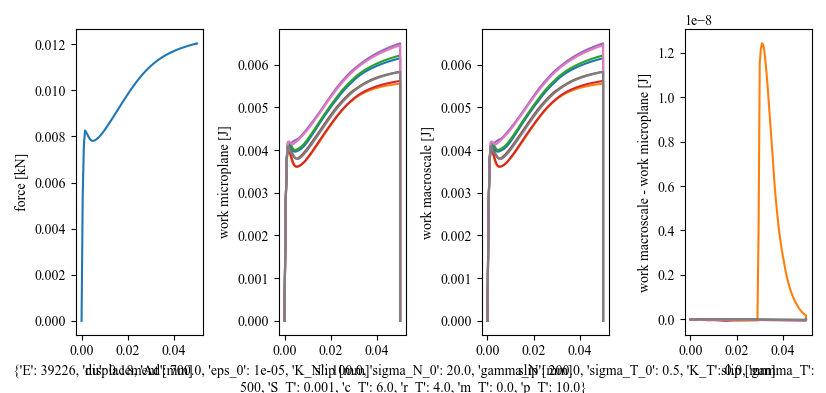

In [108]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(21*cm, 10*cm))

U_slide = np.average(m_shear_PVW.hist.U_t[:, slide_dofs], axis=-1)
F_slide = np.sum(m_shear_PVW.hist.F_t[:, slide_dofs], axis=-1)
# total_work_microplane, total_work_macro = get_total_work(m)

max_F.append(max(abs(F_compression)))

ax1.plot(-U_slide, -F_slide/1000)
ax1.set_ylabel('force [kN]', fontsize=10)
ax1.set_xlabel('displacement [mm]', fontsize=10)

total_work_microplane = np.zeros((len(m_shear_PVW.hist.state_vars),8))
total_work_macro = np.zeros((len(m_shear_PVW.hist.state_vars),8))
for i in range(len(U_slide)):
    total_work_microplane[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_microplane']])
    total_work_macro[i] = np.array([ m_shear_PVW.hist.state_vars[i][0]['total_work_macro']])

ax2.plot(-U_slide, total_work_microplane, label='radial damage')
ax2.set_ylabel('work microplane [J]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(-U_slide, total_work_macro, label='hoop damage')
ax3.set_ylabel('work macroscale [J]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)

ax4.plot(-U_slide, total_work_macro - total_work_microplane, label='hoop damage')
ax4.set_ylabel('work macroscale - work microplane [J]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()